<a href="https://colab.research.google.com/github/msvt37/Project-2/blob/main/Project2-06-07-21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluation of Multiple Algorithmic Trading Strategies for a single equity (LUV).  

The code below is a collection of strategies against the ticker (LUV) or Southwest airlines.  Any equity can be substituted.

Algorithm is a set of operations to be performed in a certain sequence to achieve a certain goal.  

Most are focused on "alpha generating strategies" or the difference between the strategy and benchmark (single stock, SPY, etc.), excess returns of strategy over benchmark.  




Simple Moving AveragesThe first type of trading strategy relies on simple moving averages (SMAs) to generate trading signals and market positionings. These trading strategies have been popularized by so-called technical analysts or chartists. The basic idea is that a shorter-term SMA being higher in value than a longer term SMA signals a long market position and the opposite scenario signals a neutral or short market position

Momentum
The basic idea behind momentum strategies is that a financial instrument is assumed to perform in accordance with its recent performance for some additional time. For example, when a stock index has seen a negative return on average over the last five days, it is assumed that its performance will be negative tomorrow, as well.

Mean Reversion
In mean-reversion strategies, a financial instrument is assumed to revert to some mean or trend level if it is currently far enough away from such a level. For example, assume that a stock trades 10 USD under its 200 days SMA level of 100. It is then expected that the stock price will return to its SMA level sometime soon.

In [1]:
import pandas as pd
import keras
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
from pylab import mpl, plt
plt.style.use('seaborn')

In [3]:
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3MB 32.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=e8e8ea50882d200b7781ab5681ace32922ad3e6b7e14f47a6737eb235104d5aa
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
#Defines the ticker symbols and dates to pull data for
symbols = ['TSLA']
start = '2015-01-01'
end = '2021-06-03'

In [5]:
#create the DF and pull in only the Adjusted Close for specified ticker
df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
#Column does not have a name, so name it
df.rename(columns={ df.columns[0] : 'Adj Close'}, inplace=True)

Turtle Trading - Please Google this and add some language around it.  Turtle Trading was an experiment in the 1980s and is a basic approach.  Turtle trading: Unlike the two other implementations, this momentum strategy doesn't use any moving average but relies on having a number of specific days, which are high and low.

In [7]:
df_turtle= df.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df_turtle) * 0.1))
signals = pd.DataFrame(index=df_turtle.index)
signals['signal'] = 0.0
signals['trend'] = df_turtle['Adj Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1


,signal,trend,RollingMax,RollingMin
Date,,,,
2015-01-02,0.0,43.862000,NaN,NaN
2015-01-05,0.0,42.018002,NaN,NaN
2015-01-06,0.0,42.256001,NaN,NaN
2015-01-07,0.0,42.189999,NaN,NaN
2015-01-08,0.0,42.124001,NaN,NaN
...,...,...,...,...
2021-05-26,0.0,619.130005,883.090027,388.040009
2021-05-27,0.0,630.849976,883.090027,388.040009
2021-05-28,0.0,625.219971,883.090027,388.040009


In [8]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [9]:
states_buy, states_sell, total_gains, invest = buy_stock(df_turtle['Adj Close'], signals['signal'])

day 259: buy 1 units at price 40.062000, total balance 9959.938000
day 263: buy 1 units at price 39.740002, total balance 9920.197998
day 266: buy 1 units at price 39.276001, total balance 9880.921997
day 267: buy 1 units at price 38.712002, total balance 9842.209995
day 268: buy 1 units at price 37.613998, total balance 9804.595997
day 272: buy 1 units at price 36.556000, total balance 9768.039997
day 273: buy 1 units at price 34.695999, total balance 9733.343998
day 275: buy 1 units at price 32.520000, total balance 9700.823997
day 276: buy 1 units at price 29.598000, total balance 9671.225998
day 278: buy 1 units at price 28.733999, total balance 9642.491999
day 316, sell 1 units at price 53.084000, investment 84.742817 %, total balance 9695.575998,
day 462: buy 1 units at price 38.158001, total balance 9657.417997
day 463: buy 1 units at price 37.604000, total balance 9619.813997
day 464: buy 1 units at price 37.484001, total balance 9582.329996
day 469: buy 1 units at price 37.070

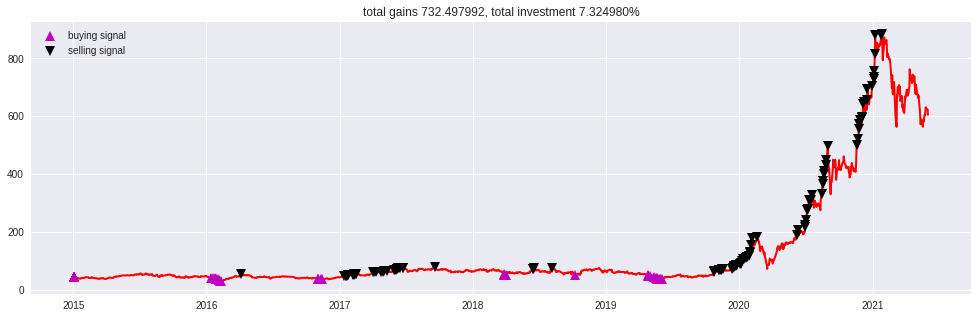

In [11]:
close = df_turtle['Adj Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

Alt Turtle Strategy 

In [17]:
df_turtle2= df.copy()

In [20]:
def turtle_trading(financial_data, window_size):
     signals = pd.DataFrame(index=financial_data.index)
     signals['orders'] = 0
     # window_size-days high
     signals['high'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).max()
     # window_size-days low
     signals['low'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).min()
     # window_size-days mean
     signals['avg'] = financial_data['Adj Close'].shift(1).\
         rolling(window=window_size).mean()
         
     signals['long_entry'] = df_turtle2['Adj Close'] > signals.high    
     signals['short_entry'] = df_turtle2['Adj Close'] < signals.low
     signals['long_exit'] = df_turtle2['Adj Close'] < signals.avg
     signals['short_exit'] = df_turtle2['Adj Close'] > signals.avg

     init=True
     position=0
     for k in range(len(signals)):
       if signals['long_entry'][k] and position==0:
             signals.orders.values[k] = 1
             position=1
       elif signals['short_entry'][k] and position==0:
             signals.orders.values[k] = -1
             position=-1
       elif signals['short_exit'][k] and position>0:
             signals.orders.values[k] = -1
             position = 0
       elif signals['long_exit'][k] and position < 0:
             signals.orders.values[k] = 1
             position = 0
       else:
             signals.orders.values[k] = 0
     return signals
ts=turtle_trading(df_turtle2, 50)



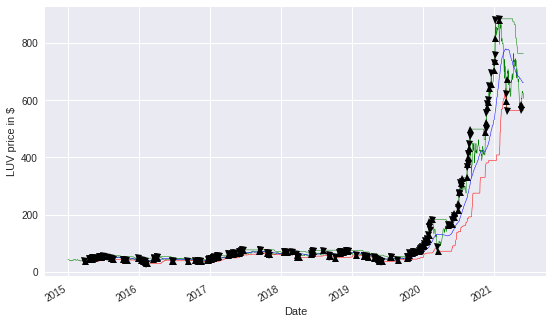

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='LUV price in $')
df_turtle2["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         df_turtle2["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         df_turtle2["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

Simple Moving Averages smooth the price trends and remove noise from the series. When asset prices move over their SMA (cross-over), it may indicate a trading signal.  Using a shorter term MA with a longer term MA is known as a "golden cross".  Investors watch for shorter term to cross above the longer term for their buy signal. When the shorter term crosses under the longer term, it's a sell signal.

In [15]:
# Set the timeframe for the Simple Moving Averages 
SMA1 = 20  
SMA2 = 252

In [16]:
# Create SMA columns and perform the calculations
df['SMA1'] = df['Adj Close'].rolling(SMA1).mean()  
df['SMA2'] = df['Adj Close'].rolling(SMA2).mean()

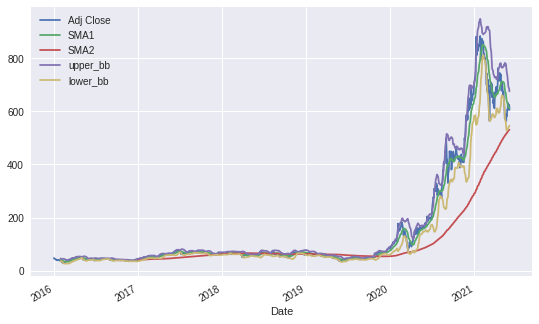

In [17]:
df.plot()

In [18]:
df.dropna(inplace=True)

In [19]:
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Adj Close'], df['SMA1'], 20)
df.tail()

,Adj Close,SMA1,SMA2,upper_bb,lower_bb
Date,,,,,
2021-05-26,619.130005,623.271503,523.520642,714.447073,532.095932
2021-05-27,630.849976,620.964001,525.384483,708.684692,533.243311
2021-05-28,625.219971,616.753000,527.202816,694.058038,539.447962
2021-06-01,623.900024,613.703000,528.965832,684.200989,543.205011
2021-06-02,605.119995,610.279001,530.667451,674.938246,545.619756


In [26]:
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 1
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(df['Adj Close'], df['lower_bb'], df['upper_bb'])


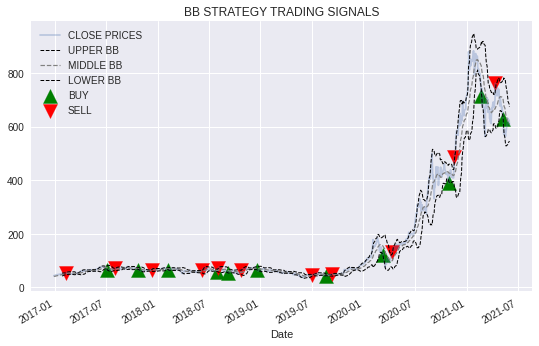

In [21]:
df['Adj Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['SMA1'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [11]:
# Check where the short term MA is greater than longe term MA, mark those with a 1 and others with -1
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [12]:
df.head()

,Adj Close,SMA1,SMA2,Position
Date,,,,
2002-01-07,17.585379,17.019541,16.703195,1
2002-01-08,17.264807,17.055187,16.690709,1
2002-01-09,16.797701,17.069247,16.677823,1
2002-01-10,16.495453,17.077854,16.659162,1
2002-01-11,16.284790,17.092564,16.639302,1


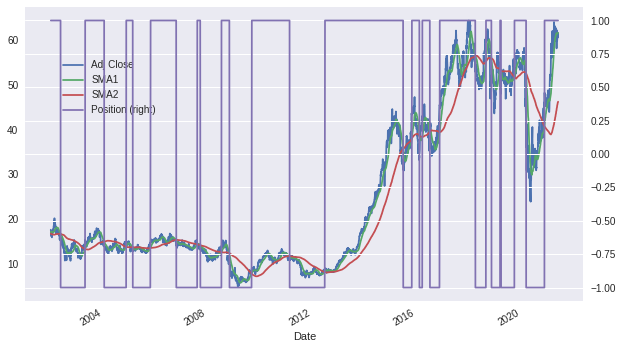

In [13]:
ax = df.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Backtest the strategy.  Calculate the logs returns and then multiply by the postion.  Performance values show the return with SMA and holding long.

In [14]:
# Calculate the log returns for investment (benchmark)
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [15]:
#
df['Strategy'] = df['Position'].shift(1) * df['Returns']

In [16]:
df.dropna(inplace=True)

In [17]:
# Sum of returns
np.exp(df[['Returns', 'Strategy']].sum())

Returns     3.461398
Strategy    0.769117
dtype: float64

In [18]:
# Calculate annualized volatility
df[['Returns', 'Strategy']].std() * 252 ** 0.

Returns     0.022206
Strategy    0.022208
dtype: float64

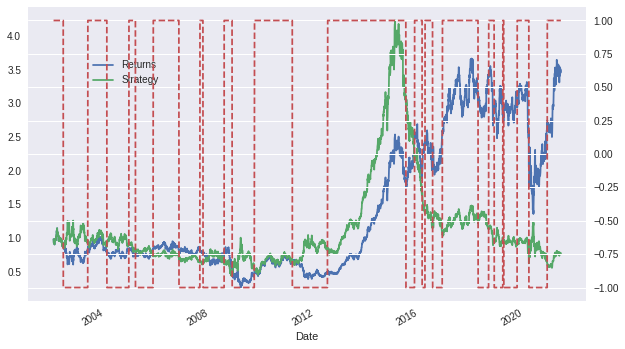

In [19]:
ax = df[['Returns', 'Strategy']].cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6))
df['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Linear OLS Regression using two features, lag 1 and lag 2 (two day and one day lags)


In [9]:
# create a copy of the adjusted closing prices in a new dataframe
data2 = df[['Adj Close']].copy()

In [10]:
# Calculate the log returns
data2['Returns'] = np.log(data2 / data2.shift(1))

In [14]:
data2.dropna(inplace=True)

In [12]:
data2.head(15)

,Adj Close,Returns
Date,,
2001-01-02,20.411097,NaN
2001-01-03,20.045078,-0.018095
2001-01-04,21.198009,0.055924
2001-01-05,21.289507,0.004307
2001-01-08,20.740505,-0.026126
2001-01-09,19.532671,-0.060000
2001-01-10,19.489969,-0.002189
2001-01-11,18.818958,-0.035035
2001-01-12,18.709152,-0.005852


In [15]:
# Establish direction of movement
data2['Direction'] = np.sign(data2['Returns']).astype(int)

In [17]:
data2.head()

,Adj Close,Returns,Direction
Date,,,
2001-01-03,20.045078,-0.018095,-1
2001-01-04,21.198009,0.055924,1
2001-01-05,21.289507,0.004307,1
2001-01-08,20.740505,-0.026126,-1
2001-01-09,19.532671,-0.060000,-1


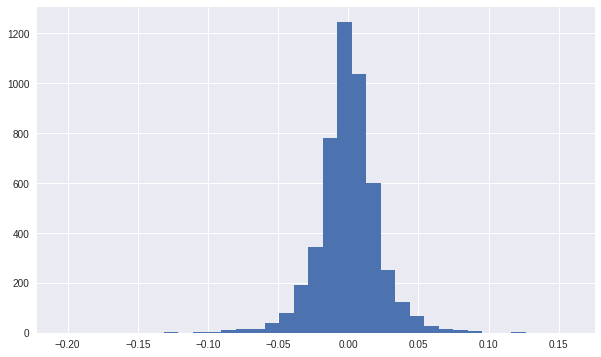

In [24]:
data2['Returns'].hist(bins=35, figsize=(10, 6))

In [20]:
lags = 2

In [21]:
# Function to create the lagged values for features
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Returns'].shift(lag)
        cols.append(col)

In [22]:
# Call function
create_lags(data2)

In [23]:
data2

,Adj Close,Returns,Direction,lag_1,lag_2
Date,,,,,
2001-01-03,20.045078,-0.018095,-1,NaN,NaN
2001-01-04,21.198009,0.055924,1,-0.018095,NaN
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307
...,...,...,...,...,...
2021-05-26,61.209999,0.010841,1,-0.002145,0.009771
2021-05-27,61.730000,0.008459,1,0.010841,-0.002145
2021-05-28,61.459999,-0.004383,-1,0.008459,0.010841


In [24]:
data2.dropna(inplace=True)

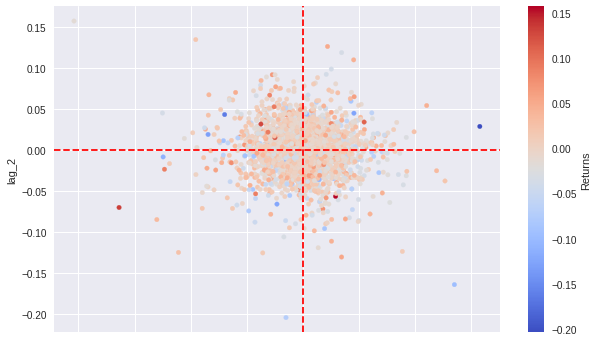

In [29]:
data2.plot.scatter(x='lag_1', y='lag_2', c='Returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
# Use linear regression model to predict movement 
model = LinearRegression()

In [27]:
data2['pos_ols_1'] = model.fit(data2[cols], data2['Returns']).predict(data2[cols])

data2['pos_ols_2'] = model.fit(data2[cols], data2['Direction']).predict(data2[cols])

In [28]:
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095,-0.003962,-0.145669
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924,0.001182,0.029976
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307,0.002074,0.080402
2001-01-10,19.489969,-0.002189,-1,-0.060000,-0.026126,0.003674,0.151602
2001-01-11,18.818958,-0.035035,-1,-0.002189,-0.060000,-0.000986,-0.017777


In [29]:
data2[['pos_ols_1', 'pos_ols_2']] = np.where(
            data2[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [30]:
data2['strat_ols_1'] = data2['pos_ols_1'] * data2['Returns']

data2['strat_ols_2'] = data2['pos_ols_2'] * data2['Returns']

In [31]:
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095,-1,-1,-0.004307,-0.004307
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924,1,1,-0.026126,-0.026126
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307,1,1,-0.060000,-0.060000
2001-01-10,19.489969,-0.002189,-1,-0.060000,-0.026126,1,1,-0.002189,-0.002189
2001-01-11,18.818958,-0.035035,-1,-0.002189,-0.060000,-1,-1,0.035035,0.035035


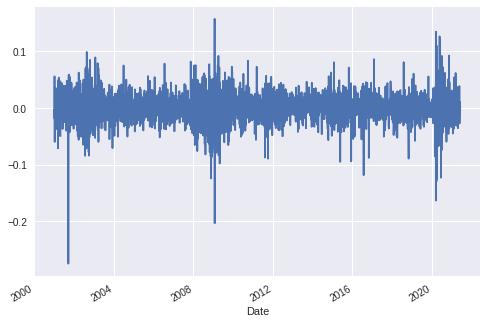

In [39]:
data2['lag_2'].plot()

In [32]:
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

Returns          2.871496
strat_ols_1    200.723634
strat_ols_2    126.811759
dtype: float64

In [33]:
# Count number of correct and false predictions by strategy
(data2['Direction'] == data2['pos_ols_1']).value_counts()

True     2668
False    2465
dtype: int64

In [34]:
(data2['Direction'] == data2['pos_ols_2']).value_counts()

True     2669
False    2464
dtype: int64

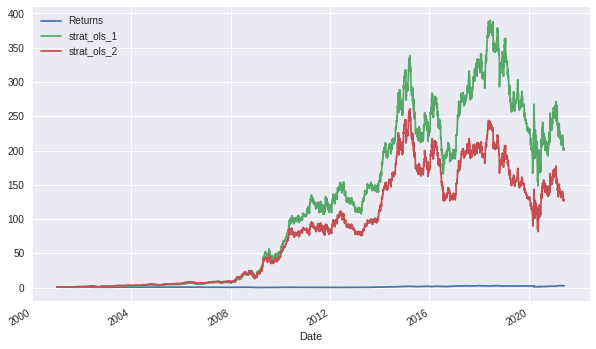

In [35]:
# Performance over time
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

Facebook Prophet :  The code below is an attempt to use FB prophet for Time Series Forecasting.  (Needs more work and may scrap)

In [47]:
data3 = df[['Adj Close']].copy()

In [48]:
data3.reset_index(inplace=True)

In [49]:
data3

,Date,Adj Close
0,2002-01-08,17.264807
1,2002-01-09,16.797701
2,2002-01-10,16.495453
3,2002-01-11,16.284790
4,2002-01-14,16.174877
...,...,...
4879,2021-05-26,61.209999
4880,2021-05-27,61.730000
4881,2021-05-28,61.459999
4882,2021-06-01,61.349998


In [60]:
data3 = data3.rename(columns={'Date':'ds', 'Adj Close':'y'})

In [61]:
data3.shape

(4884, 2)

In [54]:
df_train = data3[['ds', 'y']].iloc[:2930]
df_predict = data3[['ds']]